
# Downloading Dataset






In [1]:
!git clone https://github.com/Greibus/PD_FER.git

Cloning into 'PD_FER'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 10 (delta 1), reused 7 (delta 1), pack-reused 0
Unpacking objects: 100% (10/10), done.


In [2]:
#This is for google colab
from google.colab import files
!pip install -q kaggle
!mkdir ~/.kaggle/
!cp PD_FER/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


#This is for jupyter notebook
#import opendatasets as od
#import tarfile

In [3]:
#This is for google colab
!kaggle competitions download challenges-in-representation-learning-facial-expression-recognition-challenge -f fer2013.tar.gz


#This is for jupyter notebook
#od.download("https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge")


 79% 73.0M/92.0M [00:00<00:00, 97.5MB/s]
100% 92.0M/92.0M [00:00<00:00, 97.7MB/s]


In [4]:
#This is for google colab
! tar -xvf fer2013.tar.gz

#This is for jupyter notebook
#file = tarfile.open('challenges-in-representation-learning-facial-expression-recognition-challenge/fer2013.tar.gz')
#file.extractall()
#file.close()

fer2013/fer2013.csv
fer2013/README
fer2013/fer2013.bib
fer2013/


# Resnet Model



In [5]:

from keras.layers import Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model

from keras.applications.imagenet_utils import preprocess_input
from keras.backend import clear_session
from keras.initializers import glorot_uniform
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils.np_utils import to_categorical
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
from keras.preprocessing import image

import pandas as pd
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, TensorBoard
from keras.callbacks import ReduceLROnPlateau


## Reading Data

In [6]:
dataset_path = 'fer2013/fer2013.csv'


In [7]:
def load_fer2013():
  data = pd.read_csv(dataset_path)
  #Separate data from dataset
  groups = [g for _, g in data.groupby('Usage')]
  train = groups[2]
  val = groups[1]
  test = groups[0]

  ##Del Usage group and separate data

  train = train.drop(labels=['Usage'], axis=1)
  val = val.drop(labels=['Usage'], axis=1)
  test = test.drop(labels=['Usage'], axis=1)

  return train, val,  test


In [8]:
train, val, test = load_fer2013()

In [9]:
train.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [10]:
Y_train = train["emotion"]
Y_val = val["emotion"]
Y_test = test["emotion"]
#'Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'#

X_train = train["pixels"]
X_val = val["pixels"]
X_test = test["pixels"]

In [11]:
def preprocess(X):
    X = np.array([np.fromstring(image, np.uint8, sep=' ') for image in X])
    X = X/255.0
    X = X.reshape(-1, 48, 48, 1)
    return X

In [12]:
X_train = preprocess(X_train)
X_val = preprocess(X_val)
X_test = preprocess(X_test)

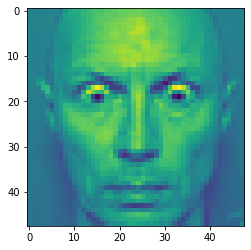

In [13]:
plt.imshow(X_train[15][:,:,0])

In [14]:
plt.imsave('test.png',X_train[15][:,:,0] )

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Counts per emotion in testing set')

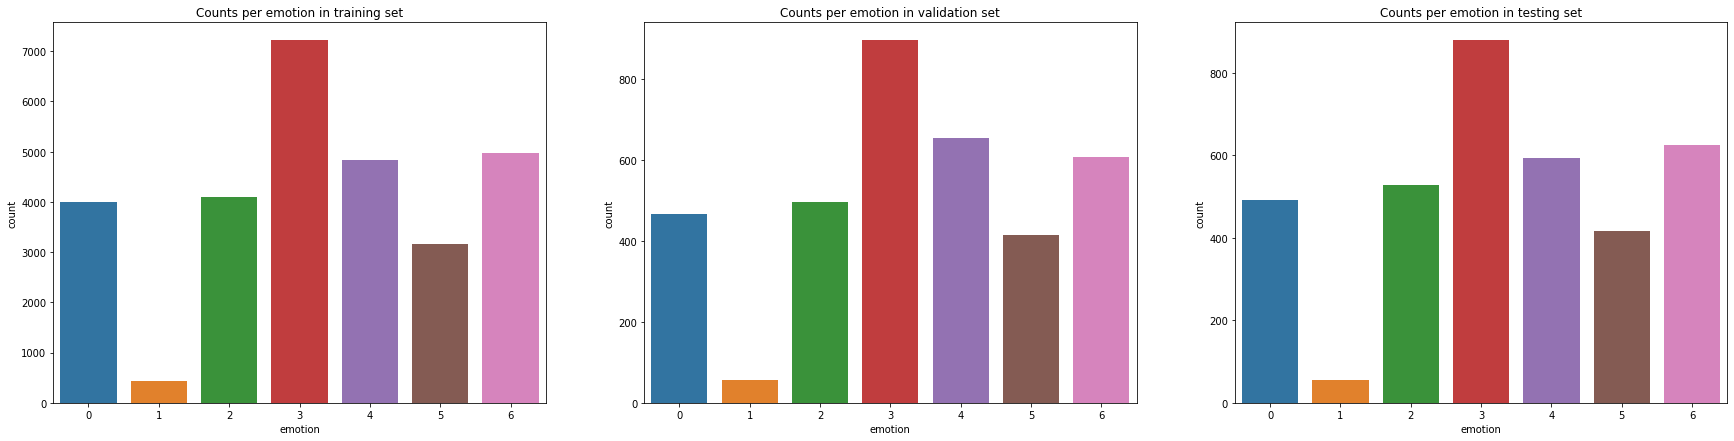

In [15]:
plt.figure(figsize=(30, 7))

plt.subplot(1,3,1)
ax = sns.countplot(Y_train)
ax.set(ylabel="count", xlabel="emotion")
plt.title("Counts per emotion in training set")

plt.subplot(1,3,2)
ax = sns.countplot(Y_val)
ax.set(ylabel="count", xlabel="emotion")
plt.title("Counts per emotion in validation set")

plt.subplot(1,3,3)
ax = sns.countplot(Y_test)
ax.set(ylabel="count", xlabel="emotion")
plt.title("Counts per emotion in testing set")

In [16]:
print("Is any label null in training set:", Y_train.isnull().any())
print("Is any label null in validation set:", Y_val.isnull().any())
print("Is any label null in testing set:", Y_test.isnull().any())


Y_train = to_categorical(Y_train, num_classes=7)
Y_val = to_categorical(Y_val, num_classes=7)
Y_test = to_categorical(Y_test, num_classes=7)

Is any label null in training set: False
Is any label null in validation set: False
Is any label null in testing set: False


## Data agumentation

In [17]:
#Data Augumentation
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        shear_range = 10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

## Model Structure

In [18]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
   
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X_shortcut,X])
    X = Activation("relu")(X)
        
    return X

In [19]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a',padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path 
    X = Conv2D(F2, (f, f), strides = (1,1), name = conv_name_base + '2b',padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c',padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1',padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X_shortcut,X])
    X = Activation("relu")(X)
        
    return X

In [20]:
def Net50(input_shape = (48,48,1), classes = 7):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    clear_session()
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    #X = ZeroPadding2D((1, 1))(X_input)
    X = X_input
    # Stage 1

    X = Conv2D(8, (3, 3), strides = (1, 1), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    # removed maxpool
    #X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [32, 32, 128], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='b')
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='c')


    # Stage 3 
    X = convolutional_block(X, f = 3, filters = [64,64,256], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [64,64,256], stage=3, block='b')
    X = identity_block(X, 3, [64,64,256], stage=3, block='c')
    X = identity_block(X, 3, [64,64,256], stage=3, block='d')

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='d')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='e')
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='f')

    # Stage 5 
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=5, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=5, block='c')

    # AVGPOOL . 
    X = AveragePooling2D((2,2), name='avg_pool')(X)
    
    # output layer
    X = Flatten()(X)
    X = Dense(512, activation = 'relu', name='fc1024' , kernel_initializer = glorot_uniform(seed=0))(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='Net50')
    model.summary()
    return model

## Training

In [21]:
patience = 25
# callbacks
log_file_path = 'model_resnet/_emotion_training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
tensorboard = TensorBoard(log_dir='./logs')
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=int(patience/2), verbose=1)
trained_models_path = 'model_resnet/_mini_XCEPTION'
model_checkpoint = ModelCheckpoint(filepath="model_resnet/model_wiehgts.hdf5", monitor='val_loss', verbose=1,save_best_only=True)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr, tensorboard]

In [22]:
from tensorflow.keras.optimizers import Adam, SGD
model = Net50(input_shape = (48, 48, 1), classes = 7)
optimizer = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
model.compile(optimizer= optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "Net50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 46, 46, 8)    80          ['input_1[0][0]']                
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 46, 46, 8)    32          ['conv1[0][0]']                  
                                                                                                  
 activation (Activation)        (None, 46, 46, 8)    0           ['bn_conv1[0][0]']               
                                                                                              

In [23]:
history = model.fit(data_generator.flow(X_train, Y_train,),
                        steps_per_epoch=len(X_train) / 32,
                        batch_size = 32,
                        epochs=30, verbose=1, callbacks=callbacks,
                        validation_data= (X_val,Y_val),
                        shuffle = True)

Epoch 1/30
898/897 [==============================] - ETA: 0s - loss: 2.0045 - accuracy: 0.2521
Epoch 1: val_loss improved from inf to 1.68606, saving model to model_resnet/model_wiehgts.hdf5
897/897 [==============================] - 108s 102ms/step - loss: 2.0045 - accuracy: 0.2521 - val_loss: 1.6861 - val_accuracy: 0.3199 - lr: 5.0000e-04
Epoch 2/30
898/897 [==============================] - ETA: 0s - loss: 1.6136 - accuracy: 0.3610
Epoch 2: val_loss improved from 1.68606 to 1.54070, saving model to model_resnet/model_wiehgts.hdf5
897/897 [==============================] - 93s 103ms/step - loss: 1.6136 - accuracy: 0.3610 - val_loss: 1.5407 - val_accuracy: 0.3962 - lr: 5.0000e-04
Epoch 3/30
898/897 [==============================] - ETA: 0s - loss: 1.4574 - accuracy: 0.4299
Epoch 3: val_loss did not improve from 1.54070
897/897 [==============================] - 92s 103ms/step - loss: 1.4574 - accuracy: 0.4299 - val_loss: 2.4220 - val_accuracy: 0.2862 - lr: 5.0000e-04
Epoch 4/30
898/

## Evaluate Model

In [34]:
model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)

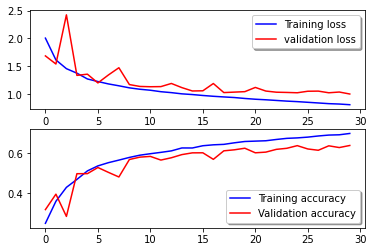

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

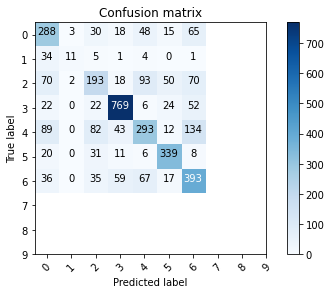

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

(48, 48)


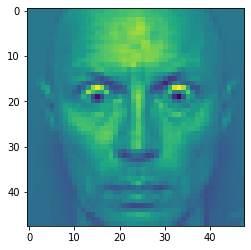

In [37]:
img = image.load_img("test.png",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape) #

In [38]:
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

In [39]:
img = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
img = img.reshape(1,48,48,1)
result = model.predict(img)
result = list(result[0])
print(result)

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]


In [40]:
img_index = result.index(max(result))
print(label_dict[img_index])
plt.show()

Sad


In [32]:
score, acc = model.evaluate(X_test, Y_test, batch_size=32)
print('Test score:', score)
print("Test accuracy:", acc)

113/113 [==============================] - 3s 28ms/step - loss: 0.9642 - accuracy: 0.6475
Test score: 0.964152455329895
Test accuracy: 0.6475341320037842
